In [1]:
!pip install keras

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [ ]:
import numpy as np
import os
import sklearn
import tensorflow as tf

In [ ]:
import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image

from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D,MaxPooling2D,Flatten,Conv1D
from keras.preprocessing import sequence

from sklearn.model_selection import train_test_split


import json
import pandas as pd
from sklearn import preprocessing
import keras
from keras.layers import Input,Dense,Lambda, Dropout
from keras.models import Model
import os
import numpy as np
from keras.preprocessing import image as image_p
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.vgg16 import VGG16
import time
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import pickle
import matplotlib.image as mpimg

from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import TimeDistributed
from keras.optimizers import Nadam

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import decode_predictions

from keras.layers import AveragePooling2D
from keras.preprocessing import image
import numpy as np

In [5]:
def add_new_last_layer(base_model, nb_classes):
    x = base_model.output
    x = AveragePooling2D((8, 8), border_mode='valid', name='avg_pool')(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)
    model = Model(input=base_model.input, output=x)
    return model

In [ ]:
base_model = InceptionV3(
    weights='imagenet',
    include_top=True
)

# We'll extract features at the final pool layer.
model = Model(
    inputs=base_model.input,
    outputs=base_model.get_layer('avg_pool').output
)

96116736/96112376 [==============================] - 37s 0us/step


In [16]:
def extract(image_path,model):
        img = image.load_img(image_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        features = model.predict(x)
        return features[0]

In [17]:
from PIL import Image
rel_dir = "/storage/"
#rel_dir = ""
batch_sz = 30

In [18]:
os.listdir(rel_dir+"/split_images")

['Aug 11th Decaying Ice',
 'Sept 5th Helicopter',
 'Aug 28th Stopped Ram Ice',
 'Aug 15th Ice Under Pressure',
 'Discoloured Ice',
 'Aug 16th-17th Helicopter',
 'Aug 20th-26th',
 'Aug 14th Decaying',
 'Sept 8th Swell',
 'Aug 29th-30th',
 'Aug 10th Decaying Ice Stopped Luis']

In [19]:
labels = []
image_features = []

labels_test = []
image_features_test = []

for label in os.listdir(rel_dir+"split_images"):
    listdir = np.array(sorted(os.listdir(rel_dir+"split_images/"+label),key=lambda x: int(x.split(".")[0])))
    print(label,len(listdir))
    batch_sz = 30
    stride = 3
    features = []
    labs = []
    label_batches = []
    for file in listdir:
        features.append(np.array(extract(rel_dir+"split_images/"+label+'/'+file,model)))
    print("Done processing features")
    for i in range(0,len(listdir),stride):
        if(np.array(features[i:i+stride*batch_sz:stride]).shape[0]!=batch_sz):
            continue
        label_batches.append(np.array(features[i:i+stride*batch_sz:stride]))
        #print(np.array(features[i:i+batch_sz]).shape)
        labs.append(label)
    X_train,X_test,y_train,y_test = train_test_split(label_batches,labs,shuffle=False,test_size=0.3)
    image_features = image_features + X_train
    labels = labels + y_train
    
    labels_test = labels_test + y_test
    image_features_test = image_features_test + X_test

Aug 11th Decaying Ice 2439
Done processing features
Sept 5th Helicopter 1490
Done processing features
Aug 28th Stopped Ram Ice 2979
Done processing features
Aug 15th Ice Under Pressure 1265
Done processing features
Discoloured Ice 676
Done processing features
Aug 16th-17th Helicopter 1309
Done processing features
Aug 20th-26th 1213
Done processing features
Aug 14th Decaying 1106
Done processing features
Sept 8th Swell 1862
Done processing features
Aug 29th-30th 3536
Done processing features
Aug 10th Decaying Ice Stopped Luis 2279
Done processing features


In [20]:
image_features = np.array(image_features)
image_features_test = np.array(image_features_test)

In [21]:
num_labels = len(np.unique(labels))

In [22]:
# permutation = np.random.permutation(len(images))
# images = images[permutation]
# labels = labels[permutation]
# image_list = [0] * len(images)
# labels_list = [0]*len(labels)
# for idx,i in enumerate(permutation):
#     image_list[idx] = images[i]
#     labels_list[idx] = labels[i]

In [23]:
num_of_train_examples = image_features.shape[0]
print(num_of_train_examples)
# datagen = ImageDataGenerator(rotation_range=90,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True)

4477


In [24]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [25]:
le.fit(list(labels))
le_labels = le.transform(labels)
le_labels_test = le.transform(labels_test)
#le_labels_test = le.transform(labels_test)
one = preprocessing.OneHotEncoder()
one.fit(list(le_labels.reshape(-1,1)))
one_labels = one.transform(le_labels.reshape(-1,1))
one_labels_test = one.transform(le_labels_test.reshape(-1,1))

In [26]:
one_labels_test.shape

(1926, 11)

In [27]:
image_f = np.zeros((len(image_features),30,2048))
for idx in range(image_features.shape[0]):
    #print(image_f[idx].shape,image_features[idx].shape)
    image_f[idx] = image_features[idx]
image_f_test = np.zeros((len(image_features_test),30,2048))
for idx in range(image_features_test.shape[0]):
    #print(image_f_test[idx].shape,image_features_test[idx].shape)
    image_f_test[idx] = image_features_test[idx]

In [28]:
model_lstm = Sequential()
model_lstm.add(LSTM(30,input_shape=(30, 2048)))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(30))
model_lstm.add(Dense(num_labels,activation='softmax'))
model_lstm.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])
model_lstm.save_weights('inception-model.h5')

In [29]:
# model_lstm.fit(image_f, one_labels, epochs=5, verbose=2)

In [30]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10,shuffle=True)
validation_cvscores = []
test_cvscores = []
for train, test in kf.split(image_f):
    model_lstm.load_weights('inception-model.h5')
    hist = model_lstm.fit(image_f[train], one_labels[train], epochs=5, verbose=0)
    print(hist.history)
    val_score = model_lstm.evaluate(image_f[test], one_labels[test], verbose=0)
    test_score = model_lstm.evaluate(image_f_test, one_labels_test, verbose=0)
    validation_cvscores.append(val_score)
    test_cvscores.append(test_score)

{'acc': [0.6872673118549413, 0.920079424041588, 0.953338297211109, 0.9746835442002402, 0.9771655496310643], 'loss': [1.0521936256999738, 0.33226331810844423, 0.1837220855536192, 0.10969906908520755, 0.09015615685727585]}
{'acc': [0.650285430687123, 0.8835939439066766, 0.9118888061553735, 0.9444030776867709, 0.9548275004873562], 'loss': [1.1838690856456402, 0.4612383461377259, 0.3215684306924087, 0.19854476160285905, 0.1571437141759338]}
{'acc': [0.6512782328416999, 0.8972449741016756, 0.9453958798709358, 0.9709605359800343, 0.9610325144342644], 'loss': [1.1736776638072428, 0.403912758651162, 0.2087646254233611, 0.13218555977990118, 0.13888843805818352]}
{'acc': [0.6542566392610493, 0.9300074459128239, 0.9377016631359792, 0.9493670887703279, 0.9647555226248824], 'loss': [1.1663338686373075, 0.3102352327805176, 0.233510540470529, 0.18217168479499524, 0.12694286277851002]}
{'acc': [0.7172995779851022, 0.9198312235251347, 0.9697195333829735, 0.9756763464879623, 0.9803921568627451], 'loss':

In [31]:
val_acc = []
for a,b in validation_cvscores:
    #print(a,b)
    val_acc.append(b)
test_acc = []    
for a,b in test_cvscores:
    #print(a,b)
    test_acc.append(b)

In [32]:
print("Validation Mean Accuracy",np.mean(val_acc))
print("Test Mean Accuracy",np.mean(test_acc))

Validation Mean Accuracy 1.0
Test Mean Accuracy 0.6700934579423778


In [33]:
print("Validation Standard Deviation",np.std(val_acc))
print("Test Standard Deviation",np.std(test_acc))

Validation Standard Deviation 0.0
Test Standard Deviation 0.03646782309449134


Text(0,0.5,'Categorial Cross Entropy')

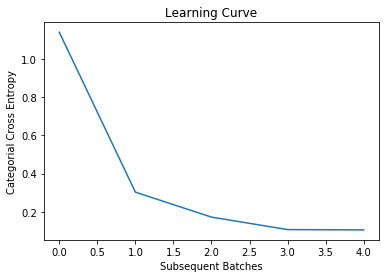

In [34]:
plt.plot(hist.history['loss'])
plt.title("Learning Curve")
plt.xlabel('Subsequent Batches')
plt.ylabel('Categorial Cross Entropy')

In [35]:
# f, axarr = plt.subplots(num_labels,2)
# f.set_figheight(30)
# f.set_figwidth(30)
# for i in range(num_labels):
#     axarr[i,0].imshow(mpimg.imread(images_to_show[i][0]))
#     axarr[i,0].title.set_text("train "+images_to_show[i][2])
#     axarr[i,1].imshow(mpimg.imread(images_to_show[i][1]))
#     axarr[i,1].title.set_text("test "+images_to_show[i][2])
# plt.show()
# plt.savefig('transferlearning.png')
# # import matplotlib.pyplot as plt
# # import matplotlib.image as mpimg
# # image = mpimg.imread(images[0])
# # plt.imshow(image)
# # plt.show()

In [36]:
import numpy as np
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})
print(np.array(validation_cvscores)[:,1]*100)
print(np.array(test_cvscores)[:,1]*100)
print(np.mean(np.array(validation_cvscores)[:,1]*100))
print(np.mean(np.array(test_cvscores)[:,1]*100))
print(np.std(np.array(validation_cvscores)[:,1]*100))
print(np.std(np.array(test_cvscores)[:,1]*100))

[100.00 100.00 100.00 100.00 100.00 100.00 100.00 100.00 100.00 100.00]
[71.75 64.43 60.96 66.30 67.08 64.95 69.11 69.16 73.21 63.14]
100.0
67.0093457942378
0.0
3.646782309449134
